<img src = "https://miro.medium.com/max/854/0*bfgOZEZqaXYB2yRo.jpg" style = "height:300px;width:100%;">
<h1 style = "float:center;">A Credit Scoring Model</h1>
<p> The Credit score willbe a probability attached to each new customer on their ability to pay a loan based on data from past loans. Those with low probabilities will either receive no loans or just receive very low loan until their ability to pay is analised via experience</p> 
<p> The data comes from the popular peer to peer lending website:  <a href = "https://www.lendingclub.com/info/download-data.action">Lending Club</p>

<h2>Data Exploration and Cleaning</h2>
<h3>Cleaning</h3>

In [32]:
#Import the Necessary Libraries
import os
os.listdir('.ipynb_checkpoints')
import pandas as pd
import os
import time

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import pickle
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 '.vscode',
 '674865876_Monthly Exchange rate (period average).csv',
 'app.py',
 'Credit Scoring Model.ipynb',
 'env',
 'LoanStats3a.csv',
 'model.pickle',
 'model.py',
 'model_two.pickle',
 'Procfile',
 'requirements.txt',
 'templates',
 'X1.csv',
 'Y1.csv',
 '__pycache__']

In [47]:
# Load the dataset
%time
loans = pd.read_csv('LoanStats3a.csv')


Wall time: 0 ns


In [48]:
#print(loans.columns)
print(loans.shape)
#loans.isnull().sum()
loans = loans.dropna(axis='columns', how='all')
loans = loans.dropna(axis=0, how='all')
print(loans.shape)

thresh = len(loans) * .6
loans.dropna(thresh = thresh, axis = 1, inplace = True)
# Checking for missing values in filtered data frame
loans.apply(lambda x: sum(x.isnull()),axis=0) 
print(loans.shape)
loans.columns

(42542, 145)
(42538, 64)
(42538, 54)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [49]:
#loans.isnull().sum()
loans = loans[(loans['loan_status']=='Fully Paid') | (loans['loan_status']=='Charged Off')]
loans['loan_status_bin'] = loans['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0}) # 0 good loans 1 bad loans
loans['disbursement_method'].value_counts()
#loans.columns


Cash    39786
Name: disbursement_method, dtype: int64

In [50]:
# The variables used for the analysis
loans.columns
columns  = ['loan_amnt',      # The Amount of Loan Requested
            'loan_status_bin',# A Binary loan status with 1 being bad loans and 0 being Good loans
            'funded_amnt',    #The amount that was Given
            'term',           # 3 or five year loan
            'int_rate',       # the interest rate charged
            'installment',    # The intallment amount paid
            'emp_length',     #How long the person has bein under employment
            'home_ownership', #What ownership they have for their home, rental owned or mortgage
            'annual_inc',     # annual income
            'verification_status',# was the income source verified
           'loan_status',     # is the loan paid fully or defaulted
            'purpose',        # The purpose for taking the  loan
            'issue_d'         #date issued
           ]
# Check for Null values
df = loans[columns]
print(df.shape)
df.isnull().sum()
#df['emp_length'].value_counts()

(39786, 13)


loan_amnt                 0
loan_status_bin           0
funded_amnt               0
term                      0
int_rate                  0
installment               0
emp_length             1078
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
issue_d                   0
dtype: int64

In [51]:
# Convert the money columns to Kenyan Shillings

Month = [i[:3] for i in df.issue_d]
Year  = [int('20'+ i[-2:]) for i in df.issue_d]

df.Month = pd.Series(Month)
df.Year = pd.Series(Year)

#import the exchange rates from Kenyan Central Bank and get the mean for the year.

KER = pd.read_csv('674865876_Monthly Exchange rate (period average).csv')#'Kenya Monthly Exchange rate 
filter1 = (2007 <= KER.Year) 
filter2  = (KER.Year <= 2011)
Ker = KER[filter1 & filter2].groupby('Year')
Exchange =Ker['United States dollar'].agg('mean')
exchange_rates = dict(Exchange)
ex = pd.Series([exchange_rates[i] for i in df.Year])

#convert the amounts to Kenyan Money Equivalent
Dollar_columns = ['loan_amnt','funded_amnt', 'installment','annual_inc']
for i in Dollar_columns:
    df[i+ '_new'] = df[i] * ex

print(df.shape)

#drop the dollar columns
df1 = df[df.columns.difference(Dollar_columns)]

df1.shape

(39786, 17)


(39786, 13)

In [52]:
#data imputation
df = df1
df['emp_length'] = df['emp_length'].fillna('10+ years') #which is the mode
interest =  [float(i[:4]) for i in df.int_rate] # converts the interest rates to numerical value
df.int_rate = interest
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39786 entries, 0 to 39785
Data columns (total 13 columns):
annual_inc_new         39786 non-null float64
emp_length             39786 non-null object
funded_amnt_new        39786 non-null float64
home_ownership         39786 non-null object
installment_new        39786 non-null float64
int_rate               39786 non-null float64
issue_d                39786 non-null object
loan_amnt_new          39786 non-null float64
loan_status            39786 non-null object
loan_status_bin        39786 non-null int64
purpose                39786 non-null object
term                   39786 non-null object
verification_status    39786 non-null object
dtypes: float64(5), int64(1), object(7)
memory usage: 4.2+ MB


In [53]:
# create Dummies for all categorical variables
lis = ['term','emp_length','home_ownership','verification_status','purpose']
df[lis[2]] = ['OTHER_Home_Ownership' if (i == 'OTHER' or i == 'NONE') else i for i in df[lis[2]]] # rename 'other'
df[lis[4]] = ['OTHER_Purposes' if (i == 'other' ) else i for i in df[lis[4]]]# rename 'other' to avoid similarities in columns
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mode()[0])

df_clean = pd.DataFrame(index = df.index)
for i in lis:
    H = df[i]
    
    H_dum = pd.get_dummies(H)
    
    B = pd.concat((df_clean,H_dum),1)
    df_clean = B
    
    print(B.shape)
df_cleans = pd.concat((df,B),1)
df_cleans.isnull().sum()
df_cleans = df_cleans[df_cleans.columns.difference(lis + ['loan_status','issue_d'])]
df_cleans.info()

(39786, 2)
(39786, 13)
(39786, 17)
(39786, 20)
(39786, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39786 entries, 0 to 39785
Data columns (total 40 columns):
 36 months              39786 non-null uint8
 60 months              39786 non-null uint8
1 year                  39786 non-null uint8
10+ years               39786 non-null uint8
2 years                 39786 non-null uint8
3 years                 39786 non-null uint8
4 years                 39786 non-null uint8
5 years                 39786 non-null uint8
6 years                 39786 non-null uint8
7 years                 39786 non-null uint8
8 years                 39786 non-null uint8
9 years                 39786 non-null uint8
< 1 year                39786 non-null uint8
MORTGAGE                39786 non-null uint8
Not Verified            39786 non-null uint8
OTHER_Home_Ownership    39786 non-null uint8
OTHER_Purposes          39786 non-null uint8
OWN                     39786 non-null uint8
RENT                  

# Data Exploration and Visualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019B4366B550>,
      dtype=object)

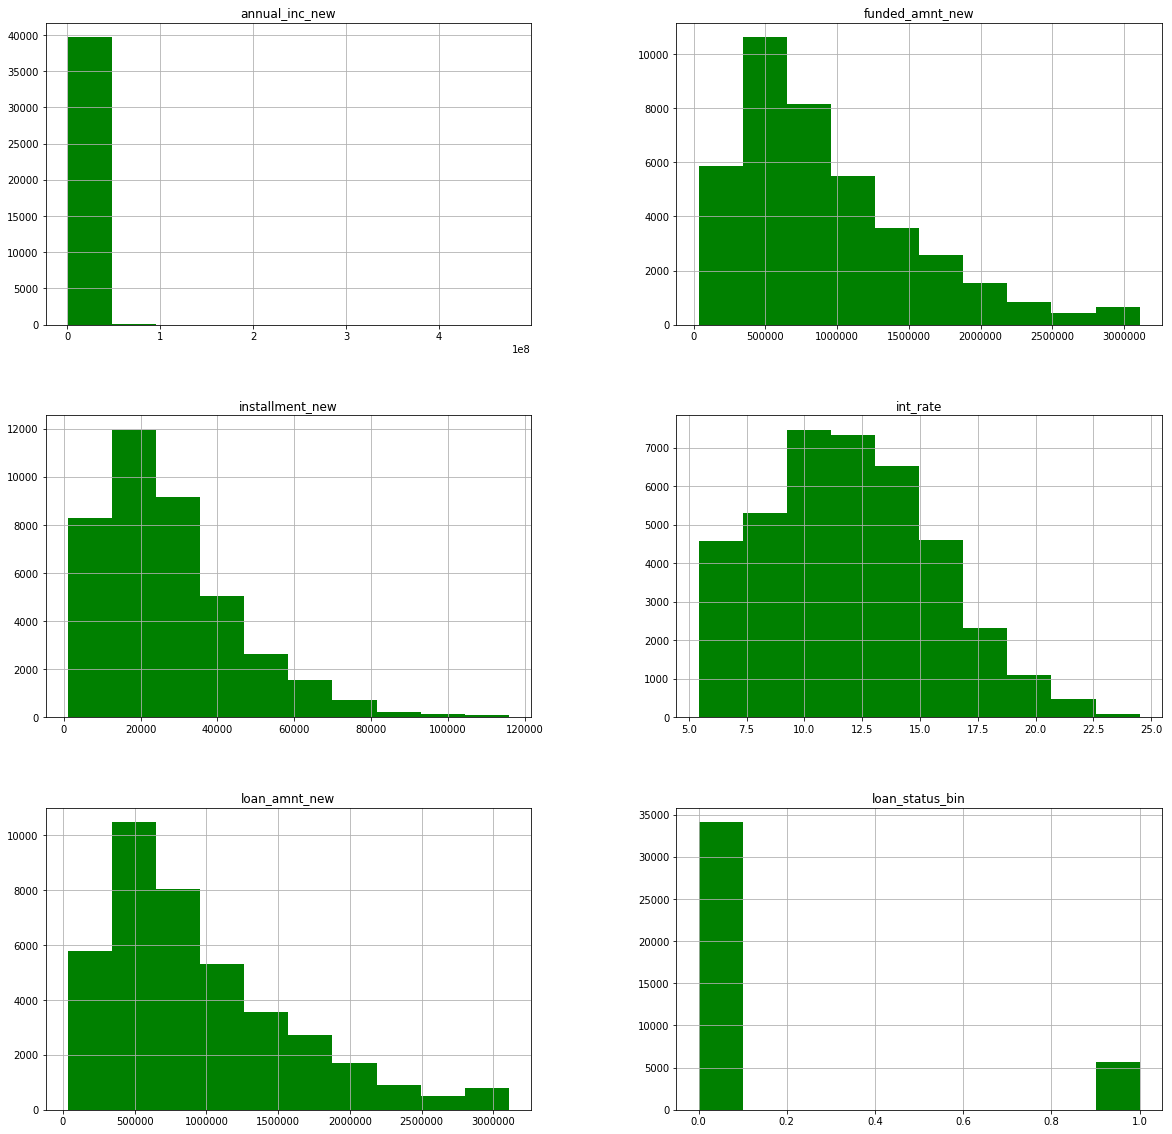

In [54]:
df.hist(figsize=(20,20),color = "green")

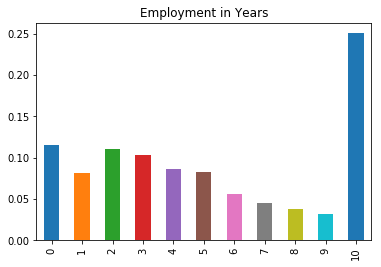

In [55]:

def emp_to_num(term):
    """converts the employment column to numerical values ranging from 0 - 10"""
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

df['emp_length_num'] = df['emp_length'].apply(emp_to_num)
plt.title('Employment in Years')
(df['emp_length_num'].value_counts().sort_index()/len(df)).plot.bar()


"Intrestingly there is no obvious connection between employment length and default rate. For example employment lengths of 8 and 9 years have almost the same default rate as employment lengths of up to 1 year. But what we can see is that an employment length of 0 or 1 has a high default rate and an emloyment length of more than 10 years has a really low default rate. So we are going to transform the feature into two features called 'long_emp' and 'short_emp'."

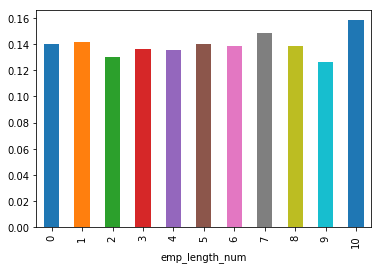

In [56]:
# is there a connection between the employment and the default rate
df.groupby('emp_length_num')['loan_status_bin'].mean().plot.bar()

'''Intrestingly there is no obvious connection between employment length and default rate. For example employment lengths of 8 and 9 years have almost the same default rate as employment lengths of up to 1 year. But what we can see is that an employment length of 0 or 1 has a high default rate and an emloyment length of more than 10 years has a really low default rate. So we are going to transform the feature into two features called 'long_emp' and 'short_emp'.'''

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

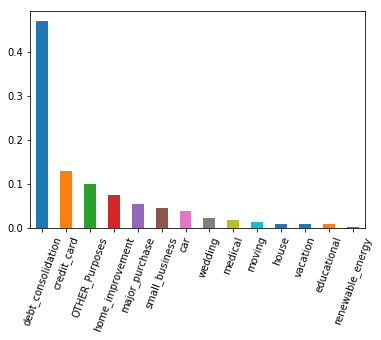

In [57]:
# distribution of interest rates
#(df['int_rate'].dropna()/len(df)).plot.hist(bins=10)
# Purpose for the loans

(df['purpose'].value_counts()/len(df)).plot.bar()
plt.xticks(rotation= 70)

The default rate is seen to be affected by the term of the loan 


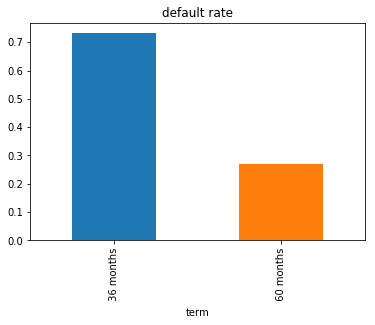

In [58]:
# The term of loans vis a vis the default rate
(df['term'].value_counts()/len(df)).plot.bar(title='value counts') # more short term loans than long term loans
df.groupby('term')['loan_status_bin'].mean().plot.bar(title='default rate') # higher default rate in longer loans
print('The default rate is seen to be affected by the term of the loan ')

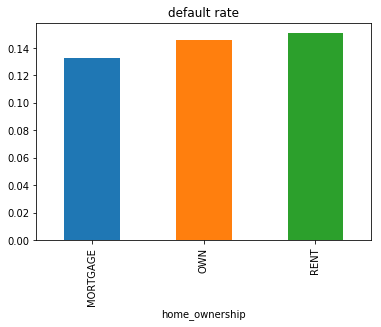

In [59]:
#Those that rent their houses have a high default rate
df[(df['home_ownership']=='MORTGAGE') | (df['home_ownership']=='OWN')| (df['home_ownership']=='RENT')].groupby('home_ownership')['loan_status_bin'].mean().plot.bar(title='default rate')

# Train the Machine Learning Model
### Create an X and Y  - input output dataset

In [102]:
# Balancing the data ti improve overall performance
filter1 = df_cleans.loan_status_bin == 0
filter2 = df_cleans.loan_status_bin == 1
good_loans = df_cleans[filter1]
bad_loans = df_cleans[filter2]
slices = good_loans.iloc[:5670,:]
new = pd.concat((bad_loans,slices),0)
print(good_loans.shape,bad_loans.shape,new.shape)

(34116, 40) (5670, 40) (11340, 40)


In [113]:
# Import the required libraries for spliting, testing and training the model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

X1 = new[df_cleans.columns.difference(lis + ['loan_status_bin'])]
Y1 = new['loan_status_bin']

# convert the dataset to csv
X11 = X1.iloc[:11339, :]
X11.to_csv("X1.csv",index = False)
Y1.to_csv("Y1.csv", index = False)

# The ML Model
X_train,X_test,Y_train,Y_test = train_test_split(X1,Y1,test_size = 0.27)

sc = MinMaxScaler()
clf1 = RandomForestClassifier( bootstrap= True,
                                max_depth= 100,
                                max_features = 2,
                                min_samples_leaf= 5,
                                min_samples_split= 8,
                                n_estimators= 100,
                                verbose = 1,
                             ) 

clf = LogisticRegression(penalty='l1', C=0.01,verbose = 1)

pipe_lr = Pipeline([('scaler', sc), ('clf', clf1)])

#Train the model
pipe_lr.fit(X_train, Y_train)

# Save the model to the local machine
filename = 'model.pickle'
pickle.dump(pipe_lr, open(filename, 'wb'))
X1.columns


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


Index([' 36 months', ' 60 months', '1 year', '10+ years', '2 years', '3 years',
       '4 years', '5 years', '6 years', '7 years', '8 years', '9 years',
       '< 1 year', 'MORTGAGE', 'Not Verified', 'OTHER_Home_Ownership',
       'OTHER_Purposes', 'OWN', 'RENT', 'Source Verified', 'Verified',
       'annual_inc_new', 'car', 'credit_card', 'debt_consolidation',
       'educational', 'funded_amnt_new', 'home_improvement', 'house',
       'installment_new', 'int_rate', 'loan_amnt_new', 'major_purchase',
       'medical', 'moving', 'renewable_energy', 'small_business', 'vacation',
       'wedding'],
      dtype='object')

In [114]:
# Classification report to see how well the model performs
preds = pipe_lr.predict(X_test)
pred_train = pipe_lr.predict(X_train) 
print(accuracy_score(Y_test,preds))# to test for over-fitting
print(classification_report(Y_test,preds))
#print(pd.DataFrame(confusion_matrix(Y_test,preds),index = ['Good','Bad'],columns = ['Good','Bad']))

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6910516002612671
             precision    recall  f1-score   support

          0       0.68      0.69      0.69      1503
          1       0.70      0.69      0.69      1559

avg / total       0.69      0.69      0.69      3062



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [75]:
# Hyper Parameter Optimisation
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

#grid_search.fit(train_features, train_labels)
#grid_search.best_params_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  8.4min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 100}

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


ROC-AUC-score:  0.751157509654627


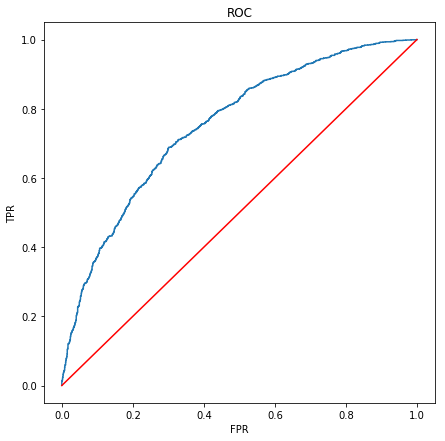

In [115]:
# Model Evaluation _ a visual approach using the (receiver_operating_curve (ROC))
test_probas = pipe_lr.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
ax = plt.figure(figsize = (7,7))
fpr, tpr, tresholds = roc_curve(Y_test, test_probas)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color = 'red')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

print('ROC-AUC-score: ', roc_auc_score(Y_test, test_probas))

Three ways to improve the model 
* Number of Mpesa transactions: Given a weight of 0.2 out of 1, so the higher the number of transactions the more the score improves
* Receive vs send. If you receive more money via mpesa than you send , improve the model, a weight of 0.5
* Number of creditors, if you have 0 creditors you get 0.3 points else you get negative points per each creditor

In [158]:
def credit_score(row):
    "returns a credit score based on the ML model"
    probability = pipe_lr.predict_proba(row)
    df = pd.DataFrame(probability)
    print(probability[:,0])
    
    return probability[:,0]


def Mpesa_no(x):
    "returns a weight depending on the number of Mpesa transactions x"
    mpesa = ["The number has to be positive" if x <0 else 5 if x < 15 else 10 if x <30 else 15 if x < 45 else 20]
    try:
        no= mpesa[0] / 100
    except:
        no = "The number has to be positive"
    return no

def receive_send(send,receive):
    "returns a positive weight if receive > send or a negative weight if receive < send. the weight is between -5 & 5"
    if send < 0 or receive < 0:
        return "The number has to be positive"
    elif receive>send:
        if send ==0:
            net = [.5]
        else:
            net = [0.15 if receive/send <1.25 else 0.2 if receive/send <1.5 else .3 if receive/send <1.75 else .4 if receive/send <2.5 else .5 ]
        return net[0]
    elif receive<send:
        if receive == 0:
            net =[ -.5 ]
        else:
             net = [-0.1 if receive/send > 0.75 else -0.2 if receive/send > 0.5 else -0.4 if receive/send > 0.3 else -.5 ]
        return net[0]
    else:# when they are equal
        return 0.1
    
def creditors(number):
    "returns .3 if you have no creditors or a negative number that grows as the number of creditors increase"
    if number < 0:
        return "The number has to be positive"
    else:
        creditors  = [.30 if number == 0 else -.05 if number ==1 else -.10 if number == 2 else -.20 if number == 3 else -.30]
        return creditors[0]
    
def scored(mpesa_no,send,receive,cred,initial_score):
    "returns a credit score that is between 1 and 0 "
    score = creditors(cred)
    Num = Mpesa_no(no)
    R_S = receive_send(send,receive)
    total = score + Num + R_S + initial_score
    return total/2


In [165]:
#test

no = 200
send = 100
receive = 10
cred =  0

row = good_loans.iloc[[0],:]
row = row[row.columns.difference(['loan_status_bin'])]
good_loans.columns

initial_score = credit_score(row)

H = scored(Mpesa_no,send,receive,cred,initial_score) 
print(initial_score*100)
print(H*100)

[0.60473717]
[60.4737173]
[80.23685865]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


<h1>Actionable items based on the model</h1>
* The model can be used as is on new customers whose data would be uploaded as csv and the output would be a credit score, the compnay would then use a score card to assign loans based on the credit score.
* The model can also be used by non datascientists using a dashboard created using ipywidgets or equivalent complete with a graphical user interface (GUI)
* The model can be used as the analytical base for a website where users log in and fill in a form, the model would use the data from this form to generate credit score that would be used to give loans. this can be achieved through use of Flask or Django in python or their equivalents in other programing languages. An example of this is vailable on github <a href = "https://github.com/sophicist/Flask-Apps/tree/master/credit%20scorer">  here</a>
* this model can also be interlinked with an already existing website that would approve loans based on the credit scores 

# Ways to improve the models
* use the full lendeable dataset
* use ensemble machine learning models such as voting to improve performance
* use deep neural networks and test performance
* use Bayes statistics to improve the model and to make it more Kenyan ( add more questions on the flask form)
* convert the dollars to Kenyan currency
* add the number of variables from the current 11
* link the model to the crb ratings and Mpesa data to get more information on the client
* Create a baseline model for the same to see how well the model performs
* look for a kenyan dataset and test the 
